<a href="https://colab.research.google.com/github/SanyamSwami123/make-more-series-andrej-karpathy/blob/main/5_makemore_WaveNet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

In [ ]:
# build the vocabulary of characters and mapping to/from integers
Chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(Chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

In [84]:
block_size = 8 # context length: how many characters do we take to predict the next one?

# build dataset
def build_dataset(words):
  # block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:

    # print(w)
    context  = [0] * block_size # padded context of 0 tokens
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2])# 10%
Xte, Yte = build_dataset(words[n2:])# 10%

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [85]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
  # calculate the forward
    if self.training:
      if x.ndim==2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameter of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [86]:
torch.manual_seed(42);

In [95]:
n_embd = 24 # the dimensionality of the character embedding vectors.
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2),  Linear((n_embd*2), n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),  Linear((n_hidden*2), n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),  Linear((n_hidden*2), n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [76]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 10, 15, 19,  5, 12,  9],
        [ 0,  0,  0,  0,  0,  0,  1, 18],
        [ 0, 23,  9, 14, 19, 20, 15, 14],
        [ 0,  0,  0,  0,  1, 14, 14,  1]])

In [89]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [91]:
model.layers[3].running_mean.shape # output of BatchNorm layer

torch.Size([1, 1, 68])

In [58]:
model.layers[0].out.shape # output of embedding layer

torch.Size([4, 8, 10])

In [59]:
model.layers[1].out.shape # ouput of flatten layer

torch.Size([4, 80])

In [61]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [96]:
# training loop
max_steps = 200000
batch_size = 32
loss1= []

for _ in  range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix] , Ytr[ix] # batch X,Y

  # forward pass
  x=Xb # input to the network: batch of inputs
  logits = model(x) # predictions
  loss = F.cross_entropy(logits, Yb) # loss function #classification efficient loss function always use this one for Class.

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #step/update the params
  lr= 0.1 if _<150000 else 0.01 # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # find good lre you will find different and more good ways online

  # track stats
  if _ % 10000 == 0: # print every once in a while
    print(f'{_:7d}/{max_steps:7d} {loss.item():.4f}')
  loss1.append(loss.log10().item())


      0/ 200000 3.3058
  10000/ 200000 2.1128
  20000/ 200000 2.0071
  30000/ 200000 2.0073
  40000/ 200000 2.1843
  50000/ 200000 2.2836
  60000/ 200000 2.1913
  70000/ 200000 2.1823
  80000/ 200000 1.8949
  90000/ 200000 2.0815
 100000/ 200000 2.1054
 110000/ 200000 1.2604
 120000/ 200000 1.6101
 130000/ 200000 2.2798
 140000/ 200000 1.8452
 150000/ 200000 1.6468
 160000/ 200000 1.8724
 170000/ 200000 1.9059
 180000/ 200000 1.6547
 190000/ 200000 1.7091


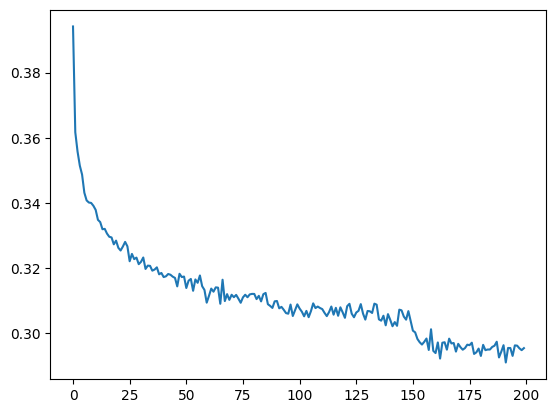

In [80]:
plt.plot(torch.tensor(loss1).view(-1,1000).mean(1))

In [98]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [97]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside  pytorch.
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7679502964019775
val 1.9829994440078735


In [50]:
# sample from the model

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples.
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

rhytan.
cairan.
prra.
salydan.
emilli.
vana.
kaylon.
joselizy.
mocabelle.
vishaus.
brodhana.
raileeks.
jova.
yazie.
yesin.
jahkeriel.
chestyn.
chio.
avanshika.
anleigha.
